In [1]:
import pandas as pd 
import pickle
import json
import re

result_df = pd.read_csv('./generated/aug_results/[all-lesions] [with-doc] [trx] [nopk] [result].csv')

In [2]:

def clean_json_response(json_res):
    cleaned_string = re.sub(r"```[a-zA-Z]*\n", "", json_res)
    json_string = re.search(r"{.*}", cleaned_string, re.DOTALL).group(0)
    json_string = json_string.replace("]\n  ]\n}", "}\n  ]\n}")
    json_string = json_string.replace('"\n  ]\n}', '"\n    }\n  ]\n}')
    # json_string = json_string.replace('\n', '').replace(',}', '}').replace(',]', ']') # form to one line.
    return json_string

def clean_and_parse_json(json_res):
    # Step 1: Remove code block markers and initial text
    cleaned_string = re.sub(r"```[a-zA-Z]*\n", "", json_res)

    # Step 2: Extract JSON content between braces
    json_string = re.search(r"{.*}", cleaned_string, re.DOTALL)
    if json_string:
        json_string = json_string.group(0)
    else:
        raise ValueError("No JSON object found in the response.")
    
    # Step 3: Remove trailing commas before closing brackets/braces
    json_string = re.sub(r',\s*([\]}])', r'\1', json_string)

    # Clean up any escape sequences or extra whitespace
    # json_string = json_string.replace('\\"', '"').replace("\\'", "'")

    # Regex to find JSON objects that do not close properly within an array
    # Add a missing closing brace before the closing bracket of an array element
    pattern = r'(\{[^}]*?)\n\s*]\s*(?=[,}])'
    json_string = re.sub(pattern, r'\1\n    }]', json_string)

    # Step 6: Maintain line breaks for readability
    json_string = re.sub(r'[\r\n]+', ' ', json_string).strip()

     # Return cleaned JSON string
    try:
        result = json.loads(json_string)
    except json.JSONDecodeError:
        print("error loading json, json=%s", json_string)
        raise
    else:
        if not isinstance(result, dict):
            raise TypeError
        return result

In [3]:
with open("separated_combined_results", "rb") as f:
    llama3_separated_combined_results = pickle.load(f)

with open("separated_combined_results_mistral", "rb") as f:
    mistral_separated_combined_results = pickle.load(f)

llama3_keywords_json = json.loads(
    clean_json_response(llama3_separated_combined_results["refined_keyword"].output)
)

llama3_keywords = [k.lower() for k in list(llama3_keywords_json.keys())]

mistral_keywords_json = clean_and_parse_json(
    mistral_separated_combined_results["refined_keyword"].output
)
mistral_keywords = [k.lower() for k in list(mistral_keywords_json.keys())]  

In [4]:
llama3_keywords

['shortness of breath',
 'fatigue',
 'swelling in the legs and feet',
 'chest pain',
 'palpitations',
 'coughing up blood',
 'fluid buildup in the lungs',
 'confusion',
 'loss of appetite',
 'pericardial effusion',
 'cardiomegaly',
 'increased cardiothoracic ratio',
 'anterior mediastinal mass',
 'prominent epicardial fat pad',
 'elevated pericardial fluid levels (ml)',
 'increased pericardial fluid protein levels (mg/dl)',
 'presence of pericardial fluid cells',
 'radiographic images showing an increased cardiothoracic ratio',
 'measurements of cardiac diameter and thoracic diameter (cm)',
 'echocardiographic images showing an enlarged heart',
 'measurements of cardiac dimensions (cm)',
 'imaging studies showing a mass in the anterior mediastinum',
 'biopsy results showing the type of tumor or mass',
 'history of pericardial effusion and cardiomegaly',
 'history of anterior mediastinal mass and prominent epicardial fat pad',
 'history of fluid accumulation',
 'history of air accumulat

In [5]:
radiologists_noted_importance_atelectasis_df = pd.read_csv('./radiologist_annotations/atalectasis.csv')
radiologists_noted_importance_enlarged_cardiac_silhouette_df = pd.read_csv('./radiologist_annotations/enlarged_card.csv')
radiologists_noted_importance_consolidation_df = pd.read_csv('./radiologist_annotations/consolidation.csv')

# drop columns 'XGBoost', 'RandomForest', 'Decision Tree', 'TabNet'
for df in [
    radiologists_noted_importance_atelectasis_df,
    radiologists_noted_importance_consolidation_df,
    radiologists_noted_importance_enlarged_cardiac_silhouette_df,
]:
    df.drop(
        columns=["XGBoost", "RandomForest", "Decision Tree", "TabNet"],
        inplace=True,
    )

def combine_radiologist_scores(dfs):
    """
    Combines multiple dataframes containing radiologist scores.
    If a feature appears in multiple dataframes, its scores are averaged.
    
    Parameters:
        dfs (list of pd.DataFrame): List of dataframes to combine.
    
    Returns:
        pd.DataFrame: Combined dataframe with averaged scores.
    """
    # Concatenate all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert all non-feature columns to numeric (ignoring errors for non-numeric values)
    for col in combined_df.columns:
        if col != "Feature":
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    
    # Group by 'Feature' and take the mean for duplicate features
    combined_df = combined_df.groupby("Feature", as_index=False).mean()
    
    return combined_df

combined_df = combine_radiologist_scores([
    radiologists_noted_importance_atelectasis_df,
    radiologists_noted_importance_consolidation_df,
    radiologists_noted_importance_enlarged_cardiac_silhouette_df
])

In [6]:
dall_m_to_graphrag = {
    "Pleural Effusion": {
        "Name in DALL-M": "pleural effusion [atelectasis]",
        "Name in GraphRAG for all": "Pleural Effusion",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Pulmonary Tuberculosis": {
        "Name in DALL-M": "pulmonary tuberculosis [atelectasis]",
        "Name in GraphRAG for all": "Pulmonary Tuberculosis",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Fatigue": {
        "Name in DALL-M": "fatigue [enlarged cardiac silhouette]",
        "Name in GraphRAG for all": "Fatigue",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Fever": {
        "Name in DALL-M": "fever [atelectasis]",
        "Name in GraphRAG for all": "Fever",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Chest pain": {
        "Name in DALL-M": "chest pain [atelectasis]",
        "Name in GraphRAG for all": "Chest pain",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Palpitations": {
        "Name in DALL-M": "palpitations [enlarged cardiac silhouette]",
        "Name in GraphRAG for all": "Palpitations",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Pericardial effusion": {
        "Name in DALL-M": "pericardial effusion [enlarged cardiac silhouette]",
        "Name in GraphRAG for all": "Pericardial effusion",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Shortness of breath": {
        "Name in DALL-M": "shortness of breath [enlarged cardiac silhouette]",
        "Name in GraphRAG for all": "Shortness of breath",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Coughing up blood": {
        "Name in DALL-M": "hemoptysis [pulmonary edema]",
        "Name in GraphRAG for all": "Coughing up blood",
        "type": "boolean",
        "disease": "pulmonary edema",
    },
    "Coughing up mucus": {
        "Name in DALL-M": "frothy sputum [pulmonary edema]",
        "Name in GraphRAG for all": "Coughing up mucus",
        "type": "boolean",
        "disease": "pulmonary edema",
    },
    "Wheezing": {
        "Name in DALL-M": "wheezing [pulmonary edema]",
        "Name in GraphRAG for all": "Wheezing",
        "type": "boolean",
        "disease": "pulmonary edema",
    },
    "Chronic Obstructive Pulmonary Disease": {
        "Name in DALL-M": "chronic obstructive pulmonary disease [atelectasis]",
        "Name in GraphRAG for all": "Chronic Obstructive Pulmonary Disease",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Smoking History": {
        "Name in DALL-M": "smoking [atelectasis]",
        "Name in GraphRAG for all": "Smoking History",
        "type": "boolean",
        "disease": "atelectasis",
    },
}

dall_m_to_graphrag_without_lesion = {
    "Pleural Effusion": {
        "Name in DALL-M": "pleural effusion",
        "Name in GraphRAG for all": "Pleural Effusion",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Pulmonary Tuberculosis": {
        "Name in DALL-M": "pulmonary tuberculosis",
        "Name in GraphRAG for all": "Pulmonary Tuberculosis",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Fatigue": {
        "Name in DALL-M": "fatigue",
        "Name in GraphRAG for all": "Fatigue",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Fever": {
        "Name in DALL-M": "fever",
        "Name in GraphRAG for all": "Fever",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Chest pain": {
        "Name in DALL-M": "chest pain",
        "Name in GraphRAG for all": "Chest pain",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Palpitations": {
        "Name in DALL-M": "palpitations",
        "Name in GraphRAG for all": "Palpitations",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Pericardial effusion": {
        "Name in DALL-M": "pericardial effusion",
        "Name in GraphRAG for all": "Pericardial effusion",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Shortness of breath": {
        "Name in DALL-M": "shortness of breath",
        "Name in GraphRAG for all": "Shortness of breath",
        "type": "boolean",
        "disease": "enlarged cardiac silhouette",
    },
    "Coughing up blood": {
        "Name in DALL-M": "hemoptysis",
        "Name in GraphRAG for all": "Coughing up blood",
        "type": "boolean",
        "disease": "pulmonary edema",
    },
    "Coughing up mucus": {
        "Name in DALL-M": "frothy sputum",
        "Name in GraphRAG for all": "Coughing up mucus",
        "type": "boolean",
        "disease": "pulmonary edema",
    },
    "Wheezing": {
        "Name in DALL-M": "wheezing",
        "Name in GraphRAG for all": "Wheezing",
        "type": "boolean",
        "disease": "pulmonary edema",
    },
    "Chronic Obstructive Pulmonary Disease": {
        "Name in DALL-M": "chronic obstructive pulmonary disease",
        "Name in GraphRAG for all": "Chronic Obstructive Pulmonary Disease",
        "type": "boolean",
        "disease": "atelectasis",
    },
    "Smoking History": {
        "Name in DALL-M": "smoking",
        "Name in GraphRAG for all": "Smoking History",
        "type": "boolean",
        "disease": "atelectasis",
    },
}

# make keys in the dall_m_to_graphrag_without_lesion to be lowercase
dall_m_to_graphrag_without_lesion = {
    k.lower(): v for k, v in dall_m_to_graphrag_without_lesion.items()
}

In [7]:
import json

def transform_to_list(x):
    fi_list = json.loads(x.replace("'", "\""))

    # remove Augmented_ prefix
    fi_list = [fi.replace("Augmented_", "").lower() for fi in fi_list]

    # transform to DALL-M feature name
    for i, fi in enumerate(fi_list):
        if fi in dall_m_to_graphrag_without_lesion:
            fi_list[i] = dall_m_to_graphrag_without_lesion[fi]["Name in DALL-M"]
            print(f"Transformed {fi} to {fi_list[i]}")
    return fi_list

result_df['fi>dummy'] = result_df['fi>dummy'].apply(transform_to_list)

Transformed shortness of breath to shortness of breath
Transformed fatigue to fatigue
Transformed chest pain to chest pain
Transformed pericardial effusion to pericardial effusion
Transformed smoking history to smoking
Transformed fever to fever
Transformed coughing up mucus to frothy sputum
Transformed pleural effusion to pleural effusion
Transformed smoking history to smoking
Transformed palpitations to palpitations
Transformed smoking history to smoking
Transformed wheezing to wheezing
Transformed coughing up mucus to frothy sputum
Transformed smoking history to smoking
Transformed shortness of breath to shortness of breath
Transformed fatigue to fatigue
Transformed chest pain to chest pain
Transformed coughing up blood to hemoptysis
Transformed pericardial effusion to pericardial effusion
Transformed fever to fever
Transformed wheezing to wheezing
Transformed coughing up mucus to frothy sputum
Transformed pleural effusion to pleural effusion
Transformed shortness of breath to short

In [8]:
result_df

,Feature Set,Model,Accuracy,AUC,Precision,F-1,Recall,p-value,#fi>dummy,#input_cols,fi>dummy
0,original,DecisionTree,0.9210,0.5822,0.1041,0.1417,0.2224,0.0000,1,9,[sbp]
1,original,RandomForest,0.9721,0.5485,0.6583,0.1711,0.0985,0.0000,5,9,"[temperature, heartrate, sbp, dbp, age]"
2,original,XGBoost,0.9611,0.5168,0.1071,0.0632,0.0448,0.0001,8,9,"[temperature, heartrate, resprate, o2sat, sbp,..."
3,original,Neural Network,0.9685,0.5097,0.1988,0.0399,0.0224,0.0000,8,9,"[temperature, heartrate, resprate, o2sat, sbp,..."
4,llama3_augmented_with_db,DecisionTree,0.9387,0.6225,0.1722,0.2150,0.2866,0.0012,6,115,"[temperature, heartrate, sbp, dbp, age, pulmon..."
5,llama3_augmented_with_db,RandomForest,0.9728,0.5575,0.7198,0.2002,0.1164,0.0000,5,115,"[temperature, heartrate, sbp, dbp, age]"
6,llama3_augmented_with_db,XGBoost,0.9698,0.5864,0.4615,0.2581,0.1791,0.0000,57,115,"[heartrate, resprate, o2sat, sbp, dbp, age, sh..."
7,llama3_augmented_with_db,Neural Network,0.9655,0.5690,0.3132,0.2002,0.1478,0.0009,24,115,"[heartrate, resprate, age, gender, palpitation..."
8,llama3_augmented_without_db,DecisionTree,0.9468,0.6006,0.1815,0.2038,0.2328,0.1550,1,115,[fluid buildup in the lungs]
9,llama3_augmented_without_db,RandomForest,0.9740,0.5820,0.7522,0.2711,0.1657,0.0000,5,115,"[temperature, heartrate, sbp, dbp, age]"


In [9]:
def combine_radiologist_scores(dfs):
    """
    Combines multiple dataframes containing radiologist scores.
    If a feature appears in multiple dataframes, its scores are averaged.
    
    Parameters:
        dfs (list of pd.DataFrame): List of dataframes to combine.
    
    Returns:
        pd.DataFrame: Combined dataframe with averaged scores.
    """
    # Concatenate all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert all non-feature columns to numeric (ignoring errors for non-numeric values)
    for col in combined_df.columns:
        if col != "Feature":
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    
    # Group by 'Feature' and take the mean for duplicate features
    combined_df = combined_df.groupby("Feature", as_index=False).mean()
    
    return combined_df

In [10]:
combined_df = combine_radiologist_scores([
    radiologists_noted_importance_atelectasis_df,
    radiologists_noted_importance_consolidation_df,
    radiologists_noted_importance_enlarged_cardiac_silhouette_df
])

In [11]:
combined_df

,Feature,Radiologist 1 Clinical Plausibility (Agreement),Radiologist 1 Clinical Relevance (Importance),Radiologist 1 Clinical Confidence (Certainty),Radiologist 2 Clinical Plausibility (Agreement),Radiologist 2 Clinical Relevance (Importance),Radiologist 2 Clinical Confidence (Certainty)
0,abdominal liquid,2.000000,2.500000,3.000000,2.500000,3.000000,3.000000
1,age,1.666667,2.000000,1.666667,1.666667,2.333333,1.666667
2,anesthesia,2.000000,2.000000,2.000000,1.500000,2.000000,2.000000
3,anxiety,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,asymptomatic,2.333333,2.333333,1.666667,2.333333,3.333333,2.333333
...,...,...,...,...,...,...,...
71,volume overload,3.000000,4.000000,3.000000,3.000000,4.000000,4.000000
72,weakness,3.000000,2.000000,2.000000,3.000000,4.000000,2.000000
73,wheezing,3.000000,2.000000,2.000000,3.000000,3.000000,2.000000
74,worsening of pain by inspiration,1.000000,1.666667,1.000000,1.000000,1.333333,1.000000


In [12]:
feature_sets_to_name = {
    "llama3_augmented_with_db": "Llama3 with GraphRAG",
    "llama3_augmented_without_db": "Llama3 without GraphRAG",
    "mistral_augmented_with_db": "Mistral with GraphRAG",
    "mistral_augmented_without_db": "Mistral without GraphRAG",
}

In [13]:
combined_df.describe()

,Radiologist 1 Clinical Plausibility (Agreement),Radiologist 1 Clinical Relevance (Importance),Radiologist 1 Clinical Confidence (Certainty),Radiologist 2 Clinical Plausibility (Agreement),Radiologist 2 Clinical Relevance (Importance),Radiologist 2 Clinical Confidence (Certainty)
count,76.000000,76.000000,76.000000,76.000000,75.000000,75.000000
mean,2.199561,2.379386,2.085526,2.133772,2.553333,2.240000
std,0.940063,1.054303,0.945356,0.908405,1.038002,0.955952
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.583333,1.000000,1.000000,1.833333,1.500000
50%,2.000000,2.166667,2.000000,2.000000,3.000000,2.000000
75%,3.000000,3.083333,3.000000,3.000000,3.333333,3.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compute_correlation_coefficient(radiologist_df, result_df, llama3_augmented_features, mistral_augmented_features):
    """
    Computes correlation coefficient between ML feature importance (score 4) and radiologists' scores (1-4 scale).
    
    Parameters:
        radiologist_df (pd.DataFrame): DataFrame containing radiologists' scores.
        result_df (pd.DataFrame): DataFrame containing ML model results.
        all_augmented_features (list): List of features in the augmented feature set.
    
    Returns:
        pd.DataFrame: Correlation coefficients for each ML model.
    """
    # We only analyze features that are in both the augmented feature set and radiologists' annotations
    
    score_columns = [
        'Radiologist 1 Clinical Plausibility (Agreement)',
        'Radiologist 1 Clinical Relevance (Importance)',
        'Radiologist 2 Clinical Plausibility (Agreement)',
        'Radiologist 2 Clinical Relevance (Importance)'
    ]
    
    # Compute the average score from two radiologists
    radiologist_df['Average Clinical Plausibility'] = radiologist_df[[score_columns[0], score_columns[2]]].mean(axis=1)
    radiologist_df['Average Clinical Relevance'] = radiologist_df[[score_columns[1], score_columns[3]]].mean(axis=1)
    
    correlation_results = []
    
    for _, row in result_df.iterrows():
        # check this row is in the llama3 or mistral
        if "llama3" in row['Feature Set'].lower():
            all_augmented_features = llama3_augmented_features
        elif "mistral" in row['Feature Set'].lower():
            all_augmented_features = mistral_augmented_features
        else:
            raise ValueError("Feature Set is not valid")

        features_to_analyze = set(all_augmented_features).intersection(set(radiologist_df['Feature'].tolist()))

        important_features = row['fi>dummy']  # ML-important features (score 4)
        model = row['Model']
        feature_set = row['Feature Set']
        
        if isinstance(important_features, str):
            important_features = eval(important_features)  # Convert to list if stored as a string
        
        matched_features = radiologist_df[radiologist_df['Feature'].isin(features_to_analyze)]
        print("# Matched features: ", len(matched_features))
        
        if not matched_features.empty:
            # Assign score 4 to important features, and 1 to non-important ones
            matched_features['ML Importance Score'] = matched_features['Feature'].apply(lambda x: 4 if x in important_features else 1)
            
            plausibility_corr = np.corrcoef(matched_features['Average Clinical Plausibility'], matched_features['ML Importance Score'])[0, 1]
            relevance_corr = np.corrcoef(matched_features['Average Clinical Relevance'], matched_features['ML Importance Score'])[0, 1]
            # Get intersection of features in the radiologist's annotations and the ML model's results
            print("ML Important score: ", matched_features['ML Importance Score'])
            print(f"[{feature_set}] - [{model}]: Plausibility Correlation: {plausibility_corr}")
            print(f"[{feature_set}] - [{model}]: Relevance Correlation: {relevance_corr}")
        else:
            print(f"Empty Matching Dataframe [{feature_set}] - [{model}]")
            plausibility_corr, relevance_corr = np.nan, np.nan
        
        correlation_results.append({
            'Model': model,
            'Feature Set': feature_set,
            'Plausibility Correlation': plausibility_corr,
            'Relevance Correlation': relevance_corr
        })
    
    return pd.DataFrame(correlation_results)

def visualize_correlation_scores(radiologist_df, result_df, llama3_augmented_features, mistral_augmented_features):
    """
    Generates bar plots showing correlation of ML feature importance with radiologists' scores.
    
    Parameters:
        radiologist_df (pd.DataFrame): DataFrame containing radiologists' scores.
        result_df (pd.DataFrame): DataFrame containing ML model results.
        all_augmented_features (list): List of features in the augmented feature set.
    """
    df_corr_scores = compute_correlation_coefficient(radiologist_df, result_df, llama3_augmented_features, mistral_augmented_features)
    
    # Plot settings
    feature_sets = df_corr_scores['Feature Set'].unique()
    num_feature_sets = len(feature_sets)
    
    fig, axes = plt.subplots(1, num_feature_sets, figsize=(6 * num_feature_sets, 6), sharey=True)
    
    if num_feature_sets == 1:
        axes = [axes]
    
    for ax, feature_set in zip(axes, feature_sets):
        df_subset = df_corr_scores[df_corr_scores['Feature Set'] == feature_set]
        df_subset.set_index("Model")[['Plausibility Correlation', 'Relevance Correlation']].plot(kind="bar", ax=ax, color=["blue", "orange"])
        ax.set_title(feature_sets_to_name[feature_set])
        ax.set_xlabel("ML Model")
        ax.set_ylabel("Correlation Coefficient")
        ax.axhline(0, color='black', linestyle='dashed', linewidth=1)
        ax.legend(title="Clinical Scores")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

    return df_corr_scores
# Example usage
# visualize_correlation_scores(radiologist_df, result_df, all_augmented_features)


# Matched features:  13
ML Important score:  10    1
12    1
13    1
25    1
26    1
48    1
49    1
51    1
55    1
57    1
61    1
63    1
73    1
Name: ML Importance Score, dtype: int64
[llama3_augmented_with_db] - [DecisionTree]: Plausibility Correlation: nan
[llama3_augmented_with_db] - [DecisionTree]: Relevance Correlation: nan
# Matched features:  13
ML Important score:  10    1
12    1
13    1
25    1
26    1
48    1
49    1
51    1
55    1
57    1
61    1
63    1
73    1
Name: ML Importance Score, dtype: int64
[llama3_augmented_with_db] - [RandomForest]: Plausibility Correlation: nan
[llama3_augmented_with_db] - [RandomForest]: Relevance Correlation: nan
# Matched features:  13
ML Important score:  10    1
12    1
13    1
25    4
26    4
48    1
49    4
51    4
55    1
57    1
61    1
63    4
73    1
Name: ML Importance Score, dtype: int64
[llama3_augmented_with_db] - [XGBoost]: Plausibility Correlation: 0.1913253998712357
[llama3_augmented_with_db] - [XGBoost]: Relevance Corr

/var/folders/g1/sgkjvx2j2sqflt1qfc9phrvh0000gn/T/ipykernel_53918/3100869008.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_features['ML Importance Score'] = matched_features['Feature'].apply(lambda x: 4 if x in important_features else 1)
/Users/jrhs/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jrhs/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/g1/sgkjvx2j2sqflt1qfc9phrvh0000gn/T/ipykernel_53918/3100869008.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

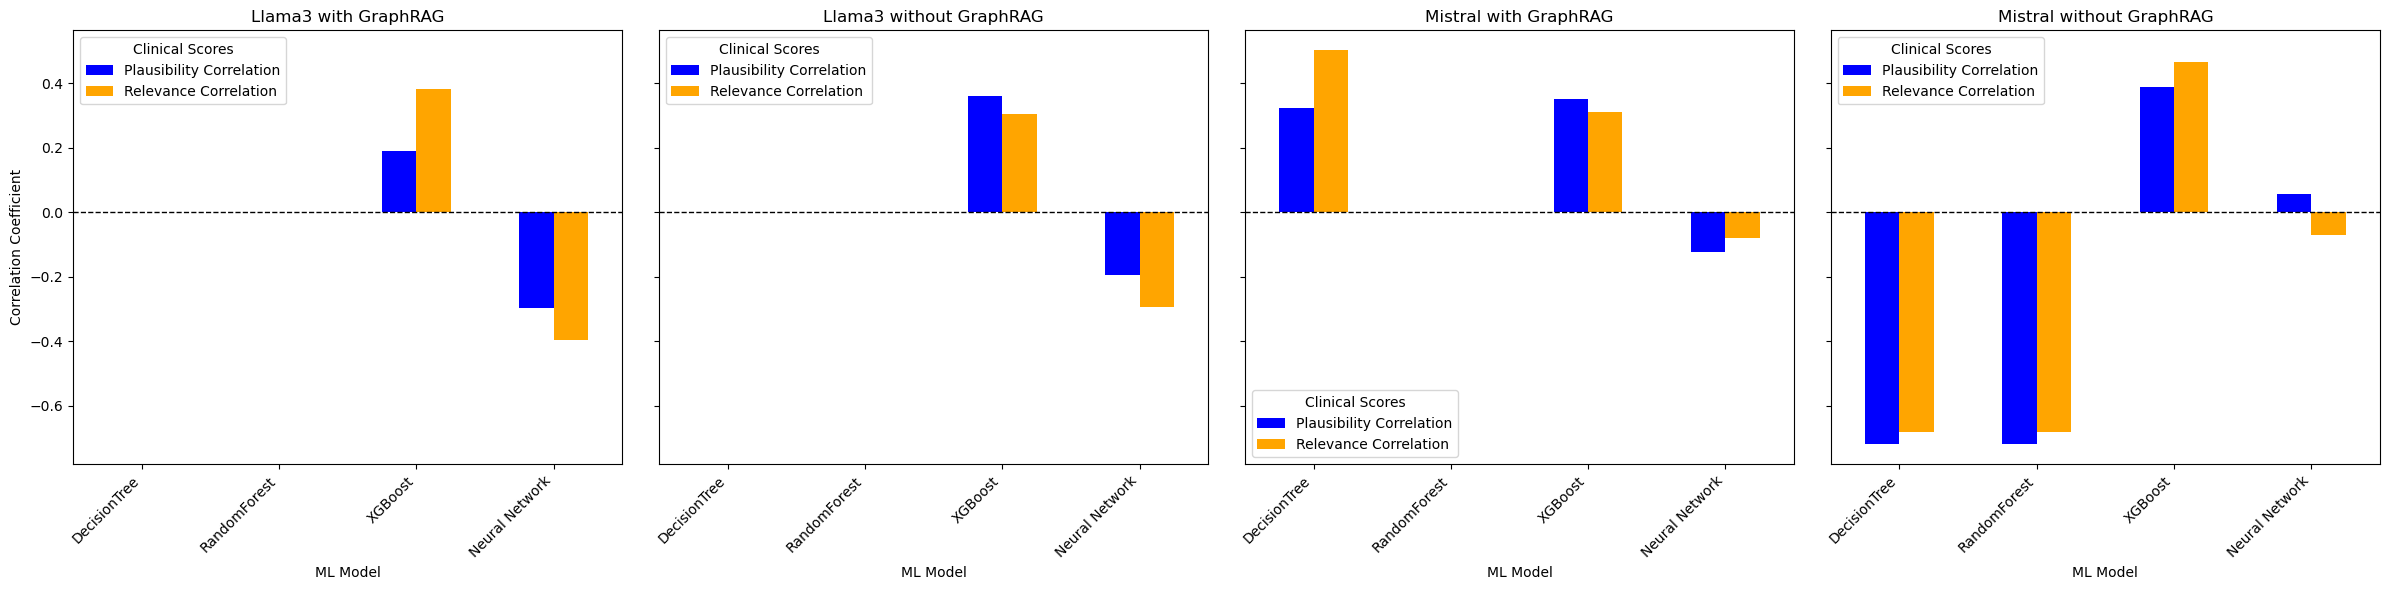

In [15]:
df_corr_scores = visualize_correlation_scores(combined_df, result_df[result_df['Feature Set'] != "original"], llama3_keywords, mistral_keywords)

In [16]:
df_corr_scores

,Model,Feature Set,Plausibility Correlation,Relevance Correlation
0,DecisionTree,llama3_augmented_with_db,NaN,NaN
1,RandomForest,llama3_augmented_with_db,NaN,NaN
2,XGBoost,llama3_augmented_with_db,0.191325,0.381297
3,Neural Network,llama3_augmented_with_db,-0.298247,-0.395076
4,DecisionTree,llama3_augmented_without_db,NaN,NaN
5,RandomForest,llama3_augmented_without_db,NaN,NaN
6,XGBoost,llama3_augmented_without_db,0.359418,0.304697
7,Neural Network,llama3_augmented_without_db,-0.194097,-0.294833
8,DecisionTree,mistral_augmented_with_db,0.324286,0.502895
9,RandomForest,mistral_augmented_with_db,NaN,NaN


In [17]:
raise StopIteration()

StopIteration: 

In [10]:
def compare_feature_sets(result_df, radiologist_df, threshold=3):
    """
    Compares feature importance between ML models and radiologists, 
    using a score threshold to filter important radiologist features.

    Parameters:
        result_df (pd.DataFrame): Dataframe containing ML model results.
        radiologist_df (pd.DataFrame): Combined radiologist scores dataframe.
        threshold (int): Minimum score (1-4 scale) to consider a feature as important.

    Returns:
        pd.DataFrame: Summary dataframe comparing ML and radiologist feature importance.
    """
    # List of radiologist score columns
    score_columns = [
        'Radiologist 1 Clinical Plausibility (Agreement)',
        'Radiologist 1 Clinical Relevance (Importance)',
        'Radiologist 1 Clinical Confidence (Certainty)',
        'Radiologist 2 Clinical Plausibility (Agreement)',
        'Radiologist 2 Clinical Relevance (Importance)',
        'Radiologist 2 Clinical Confidence (Certainty)'
    ]

    # Compute the average radiologist score for each feature
    radiologist_df["Average Score"] = radiologist_df[score_columns].mean(axis=1)

    # Select only features that meet the importance threshold
    important_radiologist_features = set(
        radiologist_df.loc[radiologist_df["Average Score"] >= threshold, "Feature"]
    )

    comparison_results = []

    # Loop through each feature set in ML results
    for _, row in result_df.iterrows():
        feature_set = row['Feature Set']
        model_name = row['Model']
        important_features = row['fi>dummy']

        # Ensure important_features is a list
        if isinstance(important_features, str):  
            important_features = eval(important_features)  # Convert string to list if needed

        # Get ML-important features for this feature set
        ml_feature_set = set(important_features)

        # Find aligned features
        aligned_features = ml_feature_set.intersection(important_radiologist_features)

        # Calculate statistics
        total_ml_features = len(ml_feature_set)
        total_radiologist_features = len(important_radiologist_features)
        aligned_count = len(aligned_features)
        alignment_ratio = aligned_count / total_ml_features if total_ml_features > 0 else 0

        # Store results
        comparison_results.append({
            'Feature Set': feature_set,
            'Model': model_name,
            'Total ML Important Features': total_ml_features,
            'Total Radiologist Important Features': total_radiologist_features,
            'Aligned Features Count': aligned_count,
            'Alignment Ratio': alignment_ratio,
            'Aligned Features': list(aligned_features)  # Store actual feature names
        })

    # Convert results into a DataFrame
    comparison_df = pd.DataFrame(comparison_results)

    return comparison_df




In [11]:
comparison_df = compare_feature_sets(result_df, combined_df)


In [12]:
comparison_df

,Feature Set,Model,Total ML Important Features,Total Radiologist Important Features,Aligned Features Count,Alignment Ratio,Aligned Features
0,original,DecisionTree,1,23,0,0.000000,[]
1,original,RandomForest,5,23,1,0.200000,[heartrate]
2,original,XGBoost,8,23,1,0.125000,[heartrate]
3,original,Neural Network,8,23,1,0.125000,[heartrate]
4,llama3_augmented_with_db,DecisionTree,6,23,1,0.166667,[heartrate]
5,llama3_augmented_with_db,RandomForest,5,23,1,0.200000,[heartrate]
6,llama3_augmented_with_db,XGBoost,56,23,4,0.071429,"[heartrate, pleural effusion, fever, shortness..."
7,llama3_augmented_with_db,Neural Network,23,23,1,0.043478,[heartrate]
8,llama3_augmented_without_db,DecisionTree,1,23,0,0.000000,[]
9,llama3_augmented_without_db,RandomForest,5,23,1,0.200000,[heartrate]


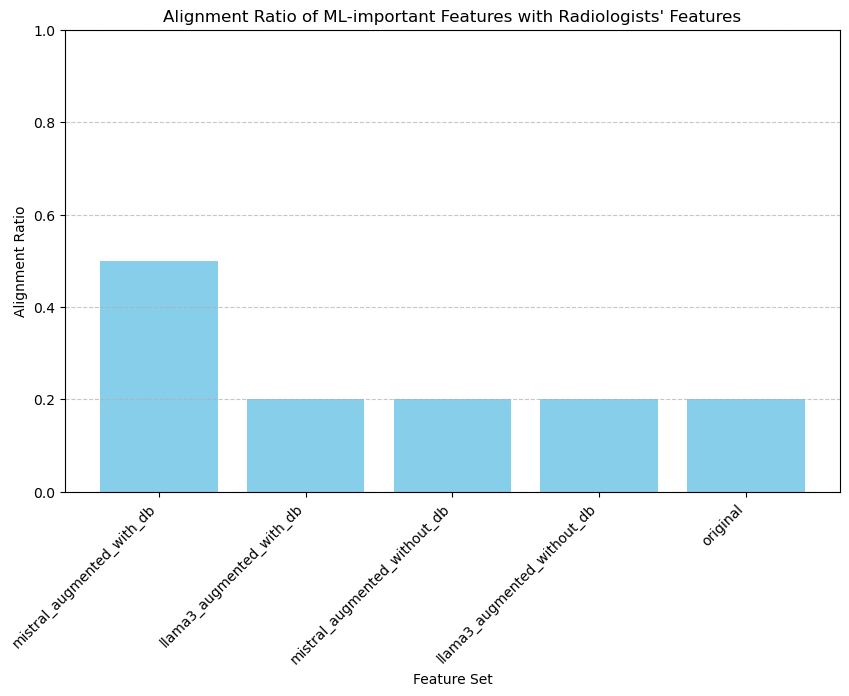

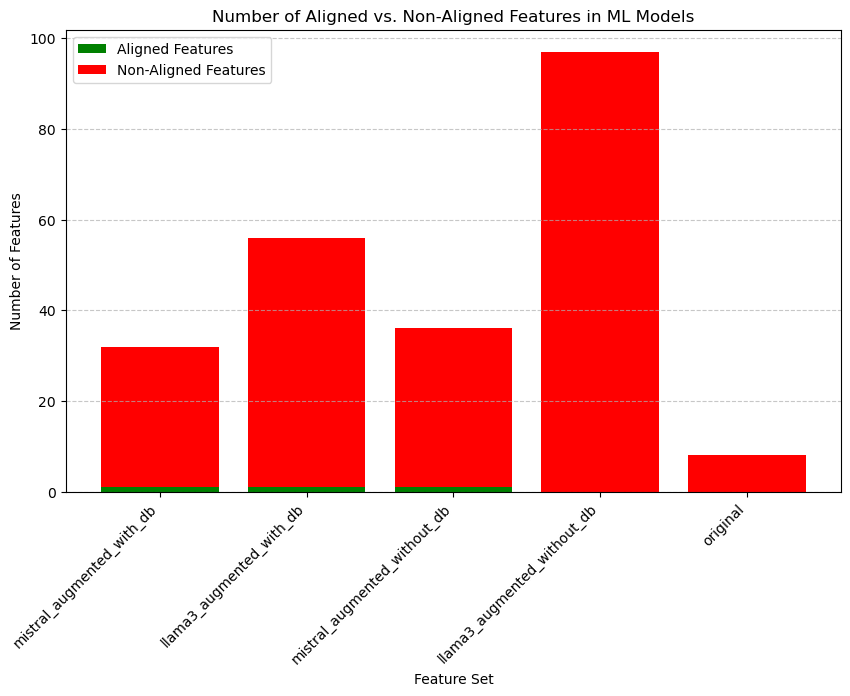

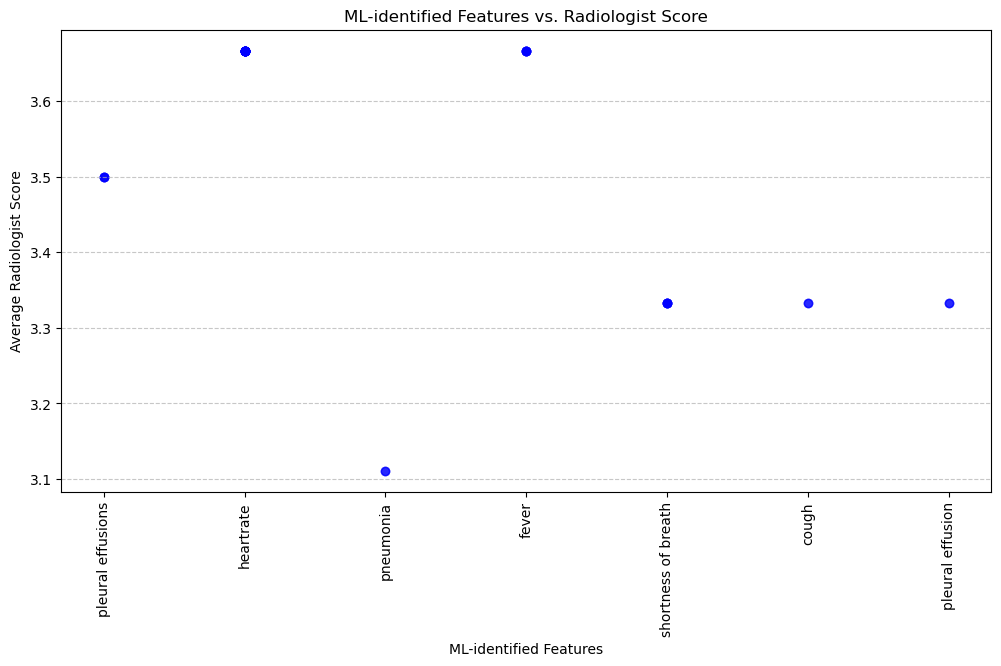

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_feature_comparison(comparison_df, radiologist_df):
    """
    Visualizes the comparison between ML-important features and radiologists' scores.

    Parameters:
        comparison_df (pd.DataFrame): DataFrame containing comparison results.
    """
    # Sort by alignment ratio for better readability
    comparison_df = comparison_df.sort_values(by="Alignment Ratio", ascending=False)

    # Bar Plot - Alignment Ratio by Feature Set
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df["Feature Set"], comparison_df["Alignment Ratio"], color='skyblue')
    plt.xlabel("Feature Set")
    plt.ylabel("Alignment Ratio")
    plt.title("Alignment Ratio of ML-important Features with Radiologists' Features")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Stacked Bar Plot - Feature Alignment Count
    plt.figure(figsize=(10, 6))
    aligned = comparison_df["Aligned Features Count"]
    non_aligned = comparison_df["Total ML Important Features"] - aligned

    plt.bar(comparison_df["Feature Set"], aligned, label="Aligned Features", color="green")
    plt.bar(comparison_df["Feature Set"], non_aligned, bottom=aligned, label="Non-Aligned Features", color="red")

    plt.xlabel("Feature Set")
    plt.ylabel("Number of Features")
    plt.title("Number of Aligned vs. Non-Aligned Features in ML Models")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Scatter Plot - Per Feature Importance (if individual feature scores exist)
    if "Aligned Features" in comparison_df.columns:
        aligned_features = sum(comparison_df["Aligned Features"], [])  # Flatten list of lists
        aligned_scores = []

        for feature in aligned_features:
            score_row = radiologist_df[radiologist_df["Feature"] == feature]
            if not score_row.empty:
                avg_score = score_row.iloc[:, 1:].mean(axis=1).values[0]  # Average across all radiologist scores
                aligned_scores.append(avg_score)
        
        if aligned_scores:
            plt.figure(figsize=(12, 6))
            plt.scatter(aligned_features, aligned_scores, color="blue", alpha=0.6)
            plt.xticks(rotation=90)
            plt.xlabel("ML-identified Features")
            plt.ylabel("Average Radiologist Score")
            plt.title("ML-identified Features vs. Radiologist Score")
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()

# Run visualization
visualize_feature_comparison(comparison_df, combined_df)


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compute_correlation(radiologist_df, result_df):
    """
    Computes correlation between ML model feature importance and radiologists' scores.
    
    Parameters:
        radiologist_df (pd.DataFrame): DataFrame containing radiologists' scores.
        result_df (pd.DataFrame): DataFrame containing ML model results.
    
    Returns:
        dict: Correlation data for high and low relevance features.
    """
    score_columns = [
        'Radiologist 1 Clinical Plausibility (Agreement)',
        'Radiologist 1 Clinical Relevance (Importance)',
        'Radiologist 1 Clinical Confidence (Certainty)',
        'Radiologist 2 Clinical Plausibility (Agreement)',
        'Radiologist 2 Clinical Relevance (Importance)',
        'Radiologist 2 Clinical Confidence (Certainty)'
    ]
    
    radiologist_df['Average Clinical Plausibility'] = radiologist_df[[score_columns[0], score_columns[3]]].mean(axis=1)
    radiologist_df['Average Clinical Relevance'] = radiologist_df[[score_columns[1], score_columns[4]]].mean(axis=1)
    
    high_relevance_corr = {}
    low_relevance_corr = {}
    ml_models = result_df['Model'].unique().tolist()
    
    for model in ml_models:
        model_data = result_df[result_df['Model'] == model]
        important_features = set()
        
        for _, row in model_data.iterrows():
            if isinstance(row['fi>dummy'], str):
                features = eval(row['fi>dummy'])
                important_features.update(features)
        
        relevant_features = radiologist_df[radiologist_df['Feature'].isin(important_features)]
        high_relevance = relevant_features[relevant_features['Average Clinical Relevance'] >= 3]
        low_relevance = relevant_features[relevant_features['Average Clinical Relevance'] < 3]
        
        high_relevance_corr[model] = [
            high_relevance['Average Clinical Plausibility'].corr(high_relevance['Average Clinical Relevance']),
            high_relevance['Average Clinical Relevance'].corr(high_relevance['Average Clinical Relevance'])
        ]
        
        low_relevance_corr[model] = [
            low_relevance['Average Clinical Plausibility'].corr(low_relevance['Average Clinical Relevance']),
            low_relevance['Average Clinical Relevance'].corr(low_relevance['Average Clinical Relevance'])
        ]
    
    return {
        'ml_models': ml_models,
        'high_relevance_corr': {
            "ML Model": ml_models,
            "Average Clinical Plausibility": [high_relevance_corr[m][0] for m in ml_models],
            "Average Clinical Relevance": [high_relevance_corr[m][1] for m in ml_models],
        },
        'low_relevance_corr': {
            "ML Model": ml_models,
            "Average Clinical Plausibility": [low_relevance_corr[m][0] for m in ml_models],
            "Average Clinical Relevance": [low_relevance_corr[m][1] for m in ml_models],
        }
    }

def visualize_correlation(radiologist_df, result_df):
    """
    Generates bar plots comparing ML models' correlation with radiologists' scores.
    
    Parameters:
        radiologist_df (pd.DataFrame): DataFrame containing radiologists' scores.
        result_df (pd.DataFrame): DataFrame containing ML model results.
    """
    correlation_data = compute_correlation(radiologist_df, result_df)
    
    ml_models = correlation_data['ml_models']
    high_relevance_corr = correlation_data['high_relevance_corr']
    low_relevance_corr = correlation_data['low_relevance_corr']
    
    # Convert to DataFrames
    df_high_relevance = pd.DataFrame(high_relevance_corr)
    df_low_relevance = pd.DataFrame(low_relevance_corr)

    # Plot settings
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot High Relevance Correlations
    ax = axes[0]
    df_high_relevance.set_index("ML Model").plot(kind="bar", ax=ax, color=["green", "yellow"])
    ax.set_title("[Atelectasis] Correlation of ML Models with Radiologists' Scores for High Relevance")
    ax.set_xlabel("ML Model")
    ax.set_ylabel("Correlation Coefficient")
    ax.axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax.legend(title="Clinical Scores")

    # Plot Low Relevance Correlations
    ax = axes[1]
    df_low_relevance.set_index("ML Model").plot(kind="bar", ax=ax, color=["darkblue", "teal"])
    ax.set_title("[Atelectasis] Correlation of ML Models with Radiologists' Scores for Low Relevance")
    ax.set_xlabel("ML Model")
    ax.axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax.legend(title="Clinical Scores")

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [17]:
correlation_data = compute_correlation(combined_df, result_df)

In [18]:
correlation_data

{'ml_models': ['DecisionTree', 'RandomForest', 'XGBoost', 'Neural Network'],
 'high_relevance_corr': {'ML Model': ['DecisionTree',
   'RandomForest',
   'XGBoost',
   'Neural Network'],
  'Average Clinical Plausibility': [nan, nan, nan, nan],
  'Average Clinical Relevance': [nan, nan, nan, nan]},
 'low_relevance_corr': {'ML Model': ['DecisionTree',
   'RandomForest',
   'XGBoost',
   'Neural Network'],
  'Average Clinical Plausibility': [nan, nan, nan, nan],
  'Average Clinical Relevance': [nan, nan, nan, nan]}}

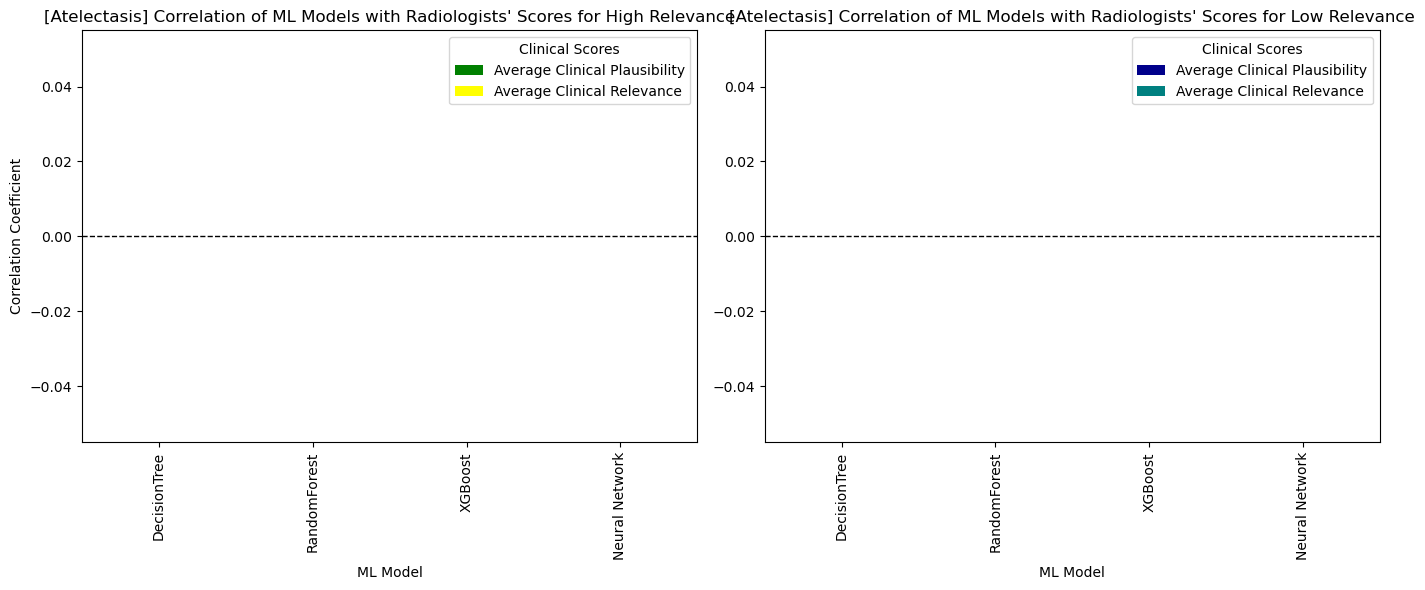

In [ ]:
visualize_correlation(combined_df, result_df)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compute_average_clinical_scores(radiologist_df, result_df, all_augmented_features):
    # we only discuss the features that are in the augmented feature set and also in the radiologist's annotations
    features_to_analyse = set(all_augmented_features).intersection(set(radiologist_df['Feature'].tolist()))

    all_avg_scores = []
    for row in result_df.iterrows():
        important_features = row['fi>dummy']
        model = row['Model']
        feature_set = row['Feature Set']

        # analyse the correlation between the important features and the radiologists' scores


def visualize_clinical_scores(radiologist_df, result_df):
    """
    Generates bar plots showing average clinical plausibility and relevance for ML models.
    
    Parameters:
        radiologist_df (pd.DataFrame): DataFrame containing radiologists' scores.
        result_df (pd.DataFrame): DataFrame containing ML model results.
    """
    avg_scores = compute_average_clinical_scores(radiologist_df, result_df)
    df_avg_scores = pd.DataFrame(avg_scores)
    
    # Plot settings
    fig, ax = plt.subplots(figsize=(10, 6))
    df_avg_scores.set_index("ML Model").plot(kind="bar", ax=ax, color=["green", "yellow"])
    
    ax.set_title("Average Clinical Plausibility and Relevance per ML Model")
    ax.set_xlabel("ML Model")
    ax.set_ylabel("Average Score")
    ax.axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax.legend(title="Clinical Scores")
    
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Example usage
# visualize_clinical_scores(radiologist_df, result_df)
